# Import

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:49629")

In [2]:
import sys
sys.path.insert(1, '..')

In [3]:
import numpy as np
import xarray as xr
import scipy
import dask
import gsw
import eos_module
import matplotlib.pyplot as plt

# Downsampling function

Coarsening by averaging over a 2D window with weights defined by area

In [4]:
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=window_size, y=window_size, boundary='trim', coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean'}).sum(skipna=True)
    area_window_sums = area_masked.coarsen(x=window_size, y=window_size, boundary='trim').sum(skipna=True)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    
    # coarsened coordinates:
    new_e1t = data['e1t'].coarsen(x=window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'],errors='ignore')
    new_e2t = data['e2t'].coarsen(x=window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'],errors='ignore')
    result['e1t'] = (['y','x'], new_e1t.values) 
    result['e2t'] = (['y','x'], new_e2t.values) 
    
    # binarize and erode the mask (to remove isolated pixels)
    # threshold = 0.0
    # new_wetmask = ndimage.binary_erosion(np.where((result['tmask'] > threshold), 1.0, 0.0))
    # result['tmask'] = (['y','x'], new_wetmask.astype(np.float32))
    # #apply new mask to data
    # result = result.where(result.tmask>0)
    return result

In [5]:
def apply_filter_downsample(dataHR, filter_coef, coarse_window_size) :
    data = dataHR.dropna(dim='y', thresh=3).dropna(dim='x', thresh=3)
    wet_mask = xr.DataArray(data.tmask, dims=['y','x'])
    area = xr.DataArray((data.e1t * data.e2t), dims=['y','x'])
    if (filter_coef > 0) :
        # Filtering with a fixed factor
        dxw = xr.DataArray(data.e1u, dims=['y','x']) # x-spacing centered at western cell edge
        dyw = xr.DataArray(data.e2u, dims=['y','x']) # y-spacing centered at western cell edge
        dxs = xr.DataArray(data.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
        dys = xr.DataArray(data.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
        dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
        dx_max = max(dxw.max(),dys.max()).values
        filter_scale = filter_coef*dx_max
#         kappa_w = xr.ones_like(dxw)
#         kappa_s = xr.ones_like(dxw)
        kappa_w = dxw * dxw / (dx_max * dx_max)
        kappa_s = dys * dys / (dx_max * dx_max)
        # define the filter
        gaussian_filter = gcm_filters.Filter(
            n_iterations=2,
            filter_scale=filter_scale,    
             dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s} )
        # apply filter to HR data
        data_filtered = xr.Dataset({}, coords=data.coords)
        data_filtered = gaussian_filter.apply(data, dims=['y', 'x'])
    else :
        data_filtered =  xr.Dataset({}, coords=data.coords)
        data_filtered = data
    # spatial coarsening
    if (coarse_window_size > 0) :
        dataLR = downsample(data_filtered, coarse_window_size, area, wet_mask)
    else : 
        dataLR = data_filtered
    return dataLR

# Data read

In [6]:
data=[dict() for i in range(6)]
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GS FMA'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GS ASO'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'AÇORES FMA'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'AÇORES ASO'})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'MEDWEST FMA'})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'MEDWEST ASO'})

In [7]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,1),y=y_slice,x=x_slice)  
coord_slice = dict(y=y_slice,x=x_slice)

In [8]:
nb_of_time_chunks = 7

In [9]:
%%time
for i in range(len(data)) :
    #current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask().\
    current_set = xr.open_mfdataset('/Users/ana/data/eNATL60_extractions/region'+data[i]['region']+'_'+data[i]['season']+'.nc', parallel=True).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    current_set = current_set.isel(data_slice)
    current_set.load()
    data[i]['HR'] = current_set

CPU times: user 1.46 s, sys: 3.52 s, total: 4.98 s
Wall time: 22.8 s


# Compute true density

In [10]:
%%time
for i in range(len(data)) :
    for dataKey in ['HR'] :
        # density anomaly (sigma0). denoted as 'true' since is computed on the basis of original (non-filtered) HR data
        data[i][dataKey]['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, data[i][dataKey]['sosaline'], data[i][dataKey]['sosstsst'], dask='parallelized').compute()
        # sqr of conservative temperature (to compute the subgrid variance further)
        data[i][dataKey]['sst_sqr'] = data[i][dataKey]['sosstsst']**2
        data[i][dataKey]['sal_sqr'] = data[i][dataKey]['sosaline']**2

CPU times: user 6.51 s, sys: 10.3 s, total: 16.8 s
Wall time: 38.5 s


# Apply filter

In [11]:
filter_size=0. # no filter
coarsening_window_size = 15 # to match eORCA025 resolution

In [12]:
%%time
for i in range(len(data)) : 
    data[i]['HR_Filtered'] = apply_filter_downsample(data[i]['HR'], filter_size, coarsening_window_size).compute().chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    data[i]['HR_Filtered'].attrs['coarsening_window_size'] = coarsening_window_size
    data[i]['HR_Filtered'].attrs['gaussian_filter_size'] = filter_size

CPU times: user 41.3 s, sys: 43.2 s, total: 1min 24s
Wall time: 2min 31s


# Compute the subgrid variance and density error

In [13]:
%%time
for i in range(len(data)) :
    ds = data[i]['HR_Filtered']
    # subgrid temp variance
    ds['var_T'] = ds['sst_sqr'] - ds['sosstsst']**2
    ds['var_S'] = ds['sal_sqr'] - ds['sosaline']**2
    # density correction
    ds['sigma0_model'] = xr.apply_ufunc(gsw.density.sigma0, ds['sosaline'], ds['sosstsst'], dask='parallelized').compute()
    ds['sigma0_delta'] = ds['sigma0_true'] - ds['sigma0_model']

CPU times: user 245 ms, sys: 82.3 ms, total: 327 ms
Wall time: 1.42 s


# Compute density derivatives

In [14]:
%%time
for i in range(len(data)) :
    ds = data[i]['HR_Filtered']
    #ds["alpha"], ds["beta"] = eos_module.alpha_beta(ds["sosaline"], ds["sosstsst"])
    temp_array = gsw.rho_second_derivatives(ds.sosaline.values, ds.sosstsst.values, 0.)
    ds['rho_sa_sa'] = xr.DataArray(temp_array[0], dims=['y', 'x', 'time_counter'])
    ds['rho_sa_ct'] = xr.DataArray(temp_array[1], dims=['y', 'x', 'time_counter'])
    ds['rho_ct_ct'] = xr.DataArray(temp_array[2], dims=['y', 'x', 'time_counter'])
    ds['rho_sa_p'] = xr.DataArray(temp_array[3], dims=['y', 'x', 'time_counter'])
    ds['rho_ct_p'] = xr.DataArray(temp_array[4], dims=['y', 'x', 'time_counter'])

    del temp_array

CPU times: user 465 ms, sys: 50.7 ms, total: 515 ms
Wall time: 961 ms


# Compute spatial finite differences for temperature and salinity 

In [15]:
def central_diffs_x(dataArray) :
    return 0.5*(dataArray.shift(x=-1) - dataArray.shift(x=1))
def central_diffs_y(dataArray) :
    return 0.5*(dataArray.shift(y=-1) - dataArray.shift(y=1))

In [16]:
%%time
for i in range(len(data)) :
    ds = data[i]['HR_Filtered']
    ds["diff_sigma0_sqr"] = central_diffs_x(ds['sigma0_model'])**2 + central_diffs_y(ds['sigma0_model'])**2
    ds["diff_T_sqr"] = central_diffs_x(ds['sosstsst'])**2 + central_diffs_y(ds['sosstsst'])**2
    ds["diff_S_sqr"] = central_diffs_x(ds['sosaline'])**2 + central_diffs_y(ds['sosaline'])**2
    ds["diff_TS"] = np.sqrt(ds["diff_T_sqr"]*ds["diff_S_sqr"])

CPU times: user 193 ms, sys: 19.9 ms, total: 213 ms
Wall time: 213 ms


In [17]:
data[i]['HR_Filtered']

<xarray.Dataset>
Dimensions:          (time_counter: 367, x: 38, y: 44)
Coordinates: (12/18)
  * time_counter     (time_counter) datetime64[ns] 2009-08-01T00:30:00 ... 20...
  * x                (x) int64 0 1 2 3 4 5 6 7 8 ... 29 30 31 32 33 34 35 36 37
  * y                (y) int64 0 1 2 3 4 5 6 7 8 ... 35 36 37 38 39 40 41 42 43
    depth            (y, x) float32 dask.array<chunksize=(44, 38), meta=np.ndarray>
    e1f              (y, x) float64 dask.array<chunksize=(44, 38), meta=np.ndarray>
    e1t              (y, x) float64 dask.array<chunksize=(44, 38), meta=np.ndarray>
    ...               ...
    lat              (y, x) float32 dask.array<chunksize=(44, 38), meta=np.ndarray>
    lon              (y, x) float32 dask.array<chunksize=(44, 38), meta=np.ndarray>
    nav_lat          (y, x) float32 dask.array<chunksize=(44, 38), meta=np.ndarray>
    nav_lon          (y, x) float32 dask.array<chunksize=(44, 38), meta=np.ndarray>
    time_centered    (time_counter) datetime64[ns] dask.array<chunksize=(7,), meta=np.ndarray>
    tmask            (y, x) float32 dask.array<chunksize=(44, 38), meta=np.ndarray>
Data variables: (12/18)
    sosaline         (y, x, time_counter) float64 dask.array<chunksize=(44, 38, 7), meta=np.ndarray>
    sosstsst         (y, x, time_counter) float64 dask.array<chunksize=(44, 38, 7), meta=np.ndarray>
    sigma0_true      (y, x, time_counter) float64 dask.array<chunksize=(44, 38, 7), meta=np.ndarray>
    sst_sqr          (y, x, time_counter) float64 dask.array<chunksize=(44, 38, 7), meta=np.ndarray>
    sal_sqr          (y, x, time_counter) float64 dask.array<chunksize=(44, 38, 7), meta=np.ndarray>
    var_T            (y, x, time_counter) float64 dask.array<chunksize=(44, 38, 7), meta=np.ndarray>
    ...               ...
    rho_sa_p         (y, x, time_counter) float64 -9.344e-10 ... -9.97e-10
    rho_ct_p         (y, x, time_counter) float64 -1.33e-09 ... -1.54e-09
    diff_sigma0_sqr  (y, x, time_counter) float64 nan nan nan ... nan nan nan
    diff_T_sqr       (y, x, time_counter) float64 dask.array<chunksize=(44, 38, 7), meta=np.ndarray>
    diff_S_sqr       (y, x, time_counter) float64 dask.array<chunksize=(44, 38, 7), meta=np.ndarray>
    diff_TS          (y, x, time_counter) float64 dask.array<chunksize=(44, 38, 7), meta=np.ndarray>
Attributes:
    coarsening_window_size:  15
    gaussian_filter_size:    0.0

# Select points in space

In [18]:
x_slice = slice(-25,-5)
y_slice = slice(-37,-13)

data_slice = dict(y=y_slice,x=x_slice)  # take every 50-th hourly output

In [19]:
for i in range(len(data)) :
    data[i]['HR_Filtered_slice'] = (data[i]['HR_Filtered'][data_slice]).copy()

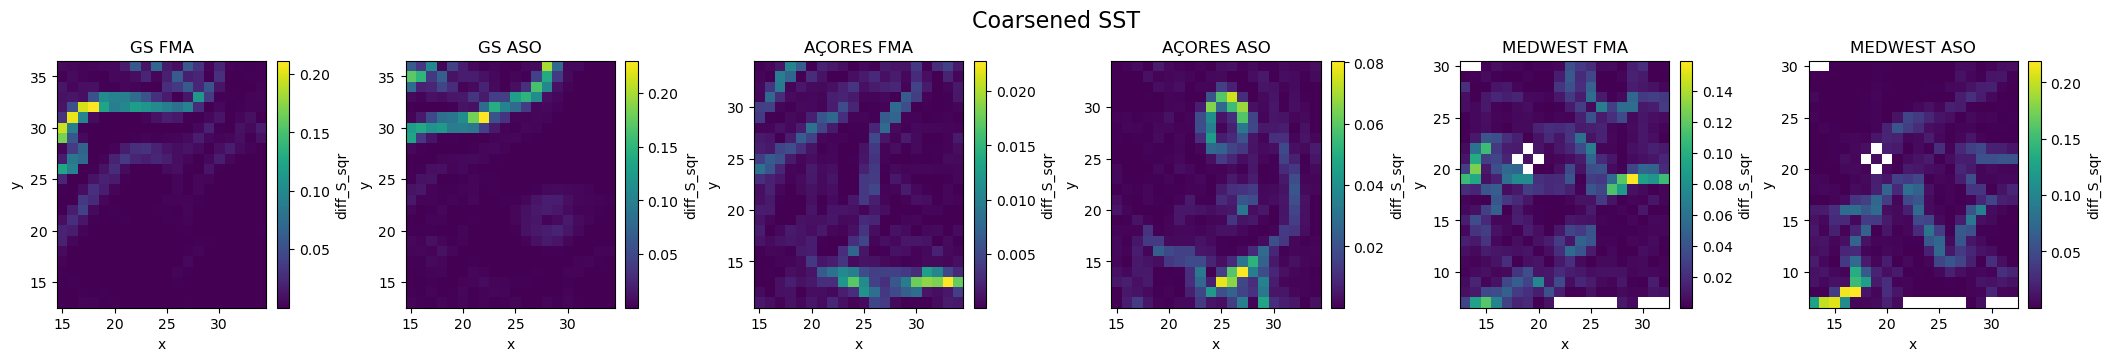

In [20]:
fig, axis = plt.subplots(ncols=len(data), nrows=1, figsize=(3.5*len(data),3.5), constrained_layout=True)
quantity='diff_S_sqr'
fig.suptitle('Coarsened SST', size=16)
for i in range(len(data)) :
    data[i]['HR_Filtered_slice'].isel(time_counter=-5)[quantity].plot(ax=axis[i])
    axis[i].set(title=data[i]['label'])

In [21]:
data[i]['HR_Filtered_slice'].isel(time_counter=-1)[quantity]

<xarray.DataArray 'diff_S_sqr' (y: 24, x: 20)>
dask.array<getitem, shape=(24, 20), dtype=float64, chunksize=(24, 20), chunktype=numpy.ndarray>
Coordinates: (12/18)
    time_counter   datetime64[ns] 2009-10-31T12:30:00
  * x              (x) int64 13 14 15 16 17 18 19 20 ... 25 26 27 28 29 30 31 32
  * y              (y) int64 7 8 9 10 11 12 13 14 15 ... 23 24 25 26 27 28 29 30
    depth          (y, x) float32 dask.array<chunksize=(24, 20), meta=np.ndarray>
    e1f            (y, x) float64 dask.array<chunksize=(24, 20), meta=np.ndarray>
    e1t            (y, x) float64 dask.array<chunksize=(24, 20), meta=np.ndarray>
    ...             ...
    lat            (y, x) float32 dask.array<chunksize=(24, 20), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(24, 20), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(24, 20), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(24, 20), meta=np.ndarray>
    time_centered  datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    tmask          (y, x) float32 dask.array<chunksize=(24, 20), meta=np.ndarray>

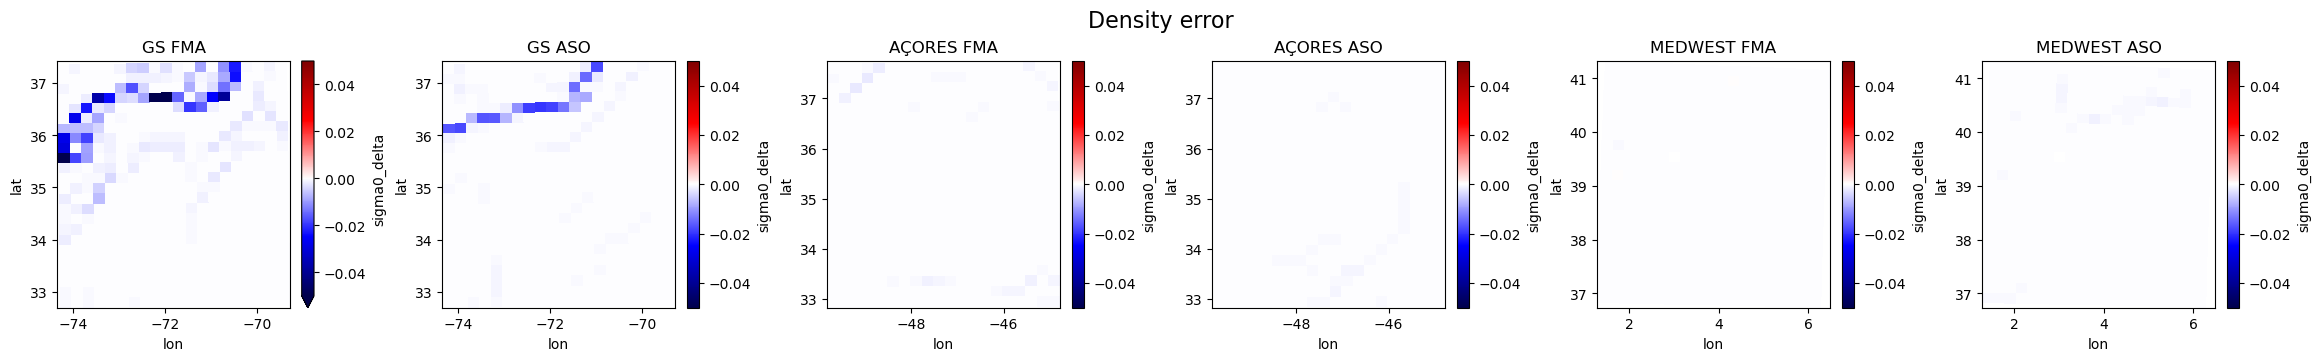

In [22]:
fig, axis = plt.subplots(ncols=len(data), nrows=1, figsize=(3.85*len(data),3.5), constrained_layout=True)
quantity='sigma0_delta'
fig.suptitle('Density error', size=16)
for i in range(len(data)) :
    data[i]['HR_Filtered_slice'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[i], cmap='seismic', vmax=0.05, vmin=-0.05)
    axis[i].set(title=data[i]['label'])

In [23]:
for i in range(len(data)) :
    data[i]['HR_Filtered_slice'].coords['x'] = np.arange(len(data[i]['HR_Filtered_slice'].coords['x']))
    data[i]['HR_Filtered_slice'].coords['y'] = np.arange(len(data[i]['HR_Filtered_slice'].coords['y']))

In [24]:
data[i]['HR_Filtered_slice']

<xarray.Dataset>
Dimensions:          (time_counter: 367, x: 20, y: 24)
Coordinates: (12/18)
  * time_counter     (time_counter) datetime64[ns] 2009-08-01T00:30:00 ... 20...
  * x                (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * y                (y) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
    depth            (y, x) float32 dask.array<chunksize=(24, 20), meta=np.ndarray>
    e1f              (y, x) float64 dask.array<chunksize=(24, 20), meta=np.ndarray>
    e1t              (y, x) float64 dask.array<chunksize=(24, 20), meta=np.ndarray>
    ...               ...
    lat              (y, x) float32 dask.array<chunksize=(24, 20), meta=np.ndarray>
    lon              (y, x) float32 dask.array<chunksize=(24, 20), meta=np.ndarray>
    nav_lat          (y, x) float32 dask.array<chunksize=(24, 20), meta=np.ndarray>
    nav_lon          (y, x) float32 dask.array<chunksize=(24, 20), meta=np.ndarray>
    time_centered    (time_counter) datetime64[ns] dask.array<chunksize=(7,), meta=np.ndarray>
    tmask            (y, x) float32 dask.array<chunksize=(24, 20), meta=np.ndarray>
Data variables: (12/18)
    sosaline         (y, x, time_counter) float64 dask.array<chunksize=(24, 20, 7), meta=np.ndarray>
    sosstsst         (y, x, time_counter) float64 dask.array<chunksize=(24, 20, 7), meta=np.ndarray>
    sigma0_true      (y, x, time_counter) float64 dask.array<chunksize=(24, 20, 7), meta=np.ndarray>
    sst_sqr          (y, x, time_counter) float64 dask.array<chunksize=(24, 20, 7), meta=np.ndarray>
    sal_sqr          (y, x, time_counter) float64 dask.array<chunksize=(24, 20, 7), meta=np.ndarray>
    var_T            (y, x, time_counter) float64 dask.array<chunksize=(24, 20, 7), meta=np.ndarray>
    ...               ...
    rho_sa_p         (y, x, time_counter) float64 -9.423e-10 ... -1.004e-09
    rho_ct_p         (y, x, time_counter) float64 -1.318e-09 ... -1.578e-09
    diff_sigma0_sqr  (y, x, time_counter) float64 0.02654 0.02864 ... 0.02749
    diff_T_sqr       (y, x, time_counter) float64 dask.array<chunksize=(24, 20, 7), meta=np.ndarray>
    diff_S_sqr       (y, x, time_counter) float64 dask.array<chunksize=(24, 20, 7), meta=np.ndarray>
    diff_TS          (y, x, time_counter) float64 dask.array<chunksize=(24, 20, 7), meta=np.ndarray>
Attributes:
    coarsening_window_size:  15
    gaussian_filter_size:    0.0

# Write dataset

In [25]:
# drop useless variables and coordiantes
for i in range(len(data)) :
    data[i]['HR_Filtered_slice'] = data[i]['HR_Filtered_slice'].drop(['time_centered', 'tmask', 'nav_lat', 'nav_lon', 'depth', 'e1f', 'e2f', 'e1u', 'e2u', 'e1v', 'e2v', 'e1t', 'e2t', 'sigma0_true', 'sst_sqr', 'sal_sqr'], errors='ignore')
    data[i]['HR_Filtered_slice'].attrs['label'] = data[i]['label']

In [26]:
for i in range(len(data)) :
    data[i]['HR_Filtered_slice'].attrs['region'] = data[i]['region']
    data[i]['HR_Filtered_slice'].attrs['season'] = data[i]['season']

In [27]:
# for i in range(len(data)) :
#     data[i]['HR_Filtered_slice'] = data[i]['HR_Filtered_slice'].bfill(dim='y').bfill(dim='x')
#     if (np.isnan(data[i]['HR_Filtered_slice']['diff_S_sqr']).any() or np.isnan(data[i]['HR_Filtered_slice']['sigma0_delta']).any()) :
#         print("NANS in data ")

In [28]:
# # pandas format
# for i in range(len(data)) :
#     for it, counter in enumerate(data[i]['HR_Filtered']['time_counter']) :
#         (data[i]['HR_Filtered'].isel(time_counter=it).drop('time_counter')).to_dataframe().to_csv("datasets/dataset"+str(i)+"_it"+str(it)+".csv")

In [30]:
# netcdf format
for i in range(len(data)) :
    data[i]['HR_Filtered_slice'].to_netcdf("datasets/dataset"+str(i)+".nc")

In [31]:
index_table = np.transpose(np.stack([np.concatenate([np.full(len(data[i]['HR']['time_counter']), i) for i in range(len(data))]),\
         np.concatenate([np.arange(len(data[i]['HR']['time_counter'])) for i in range(len(data))])]))

In [32]:
index_table.shape

(2166, 2)